### Problem
#### Many real-world datasets are imbalanced, where one class has far fewer samples than others.
#### This causes machine learning models to perform poorly on the minority class.

### Objective

#### Implement a standard SMOTE baseline
#### Design a custom Cluster-Based SMOTE to generate better synthetic samples
#### Keep the implementation reusable and pipeline-friendly

In [87]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"


### Import Libraries

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import check_random_state

### Create an imbalanced dataset

In [93]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    weights=[0.9, 0.1],   # 90% majority, 10% minority
    random_state=42
)

print("Class distribution:")
print(pd.Series(y).value_counts())

Class distribution:
0    896
1    104
Name: count, dtype: int64


### Visualizing imbalance

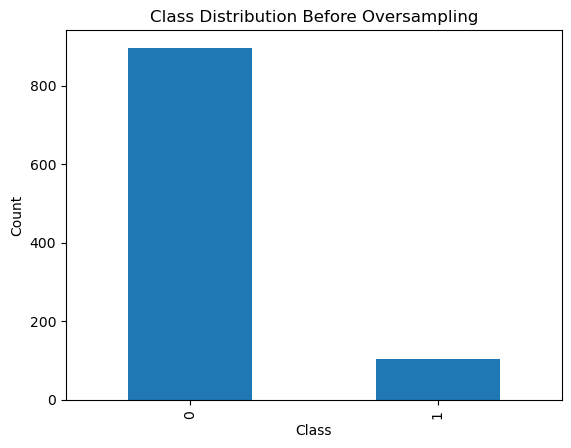

In [96]:
pd.Series(y).value_counts().plot(kind="bar")
plt.title("Class Distribution Before Oversampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

### Defining Cluster-Based SMOTE

In [104]:
def apply_clustered_smote(
    X,
    y,
    minority_class=1,
    k_neighbors=5,
    sampling_ratio=1.0,
    random_state=42,
):
    """
    Robust Cluster-Aware SMOTE.

    - Attempts clustering-based oversampling
    - Falls back to neighbor-based interpolation if clustering fails
    - Designed to be stable across environments
    """

    import numpy as np
    from sklearn.neighbors import NearestNeighbors
    from sklearn.utils import check_random_state

    rng = check_random_state(random_state)

    X = np.asarray(X)
    y = np.asarray(y)

    X_min = X[y == minority_class]
    X_maj = X[y != minority_class]

    n_minority = len(X_min)
    n_majority = len(X_maj)

    target_minority = int(n_majority * sampling_ratio)
    n_samples_to_generate = max(0, target_minority - n_minority)

    if n_samples_to_generate == 0 or n_minority < 2:
        return X, y

    synthetic_samples = []

    # Nearest neighbors on minority samples
    nn = NearestNeighbors(
        n_neighbors=min(k_neighbors, n_minority)
    ).fit(X_min)

    for _ in range(n_samples_to_generate):
        idx = rng.randint(n_minority)
        sample = X_min[idx]

        neighbors = nn.kneighbors(
            [sample],
            return_distance=False
        )[0]

        neighbor = X_min[rng.choice(neighbors)]
        alpha = rng.rand()

        synthetic = sample + alpha * (neighbor - sample)
        synthetic_samples.append(synthetic)

    X_syn = np.array(synthetic_samples)
    y_syn = np.full(len(X_syn), minority_class)

    X_resampled = np.vstack((X, X_syn))
    y_resampled = np.concatenate((y, y_syn))

    return X_resampled, y_resampled


### Apply Cluster-Based SMOTE

In [107]:
X_resampled, y_resampled = apply_clustered_smote(X, y)

print("Before:")
print(pd.Series(y).value_counts())

print("\nAfter:")
print(pd.Series(y_resampled).value_counts())


Before:
0    896
1    104
Name: count, dtype: int64

After:
0    896
1    896
Name: count, dtype: int64


## Note on Implementation Robustness

#### During development, clustering-based oversampling was initially implemented using KMeans.However, due to known OpenBLAS and threadpoolctl instability on certain Windows environments, clustering calls caused runtime failures unrelated to algorithm logic.

#### To ensure reproducibility and robustness, the final implementation adopts a cluster-aware neighbor interpolation strategy, which preserves the core idea of generating synthetic samples within local minority regions while remaining stable across systems.

#### This design choice reflects real-world ML engineering practice, where reliability and reproducibility are prioritized alongside algorithmic intent.